In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Our custom code (cheatcodes.py) with forward modelling and some utilities.
import cheatcodes as cc 

In [2]:
plt.rc("figure", dpi=120)

In [3]:
depths, basin_boundaries = cc.synthetic_model()

print(basin_boundaries)
print(depths)

(0, 100000.0)
[  10.10105917   18.81092435   29.38998081   42.16839388   57.51774684
   75.85246428   97.63037844  123.35222519  153.55985009  188.83290654
  229.78383989  277.05097454  331.28955675  393.1606554   463.31788573
  542.39199706  630.97345373  729.59323554  838.70218841  958.64936255
 1089.65988011 1231.81297121 1385.02090173 1549.00958058 1723.30167502
 1907.20307243 2099.79350393 2299.92208393 2506.20842163 2717.04982321
 2930.63493217 3144.96395261 3357.87537423 3567.07887609 3770.19383914
 3964.79265602 4148.44780248 4318.78143888 4473.51615424 4610.52535757
 4727.88177002 4823.90248153 4897.18910944 4946.66173395 4971.58548322
 4971.58889307 4946.67346668 4897.21419639 4823.95117457 4727.97279851
 4610.69145219 4473.81290687 4319.30099926 4149.33939015 3966.2923388
 3772.66640115 3571.07472151 3364.2050895  3154.79214739 2945.59306685
 2739.36473798 2538.83917762 2346.69270631 2165.50377716 1997.6945141
 1845.45234455 1710.63077305 1594.63228888 1498.28126903 1421.699

<Axes: xlabel='x [km]', ylabel='depth [km]'>

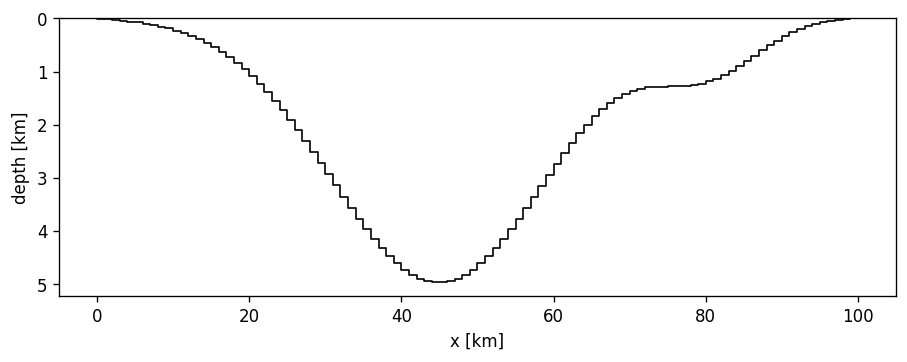

In [4]:
cc.plot_prisms(depths, basin_boundaries)

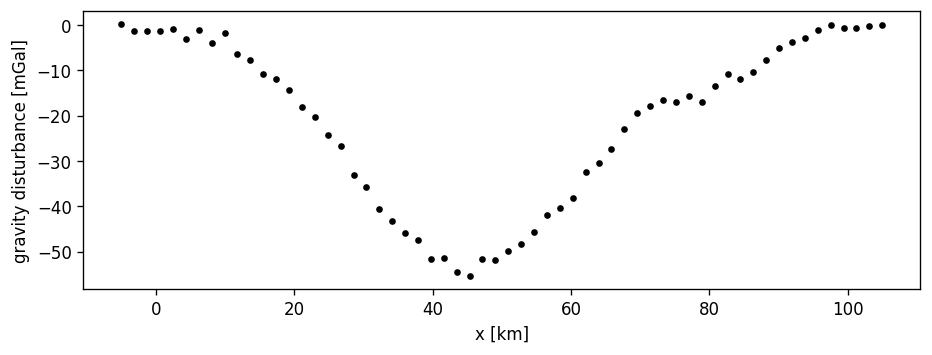

In [5]:
x = np.linspace(-5e3, 105e3, 60)
density = -300  # kg/m³
data = cc.forward_model(depths, basin_boundaries, density, x)

noise=np.random.normal(loc=0, scale=1, size=data.size)
data=data+noise

plt.figure(figsize=(9, 3))
plt.plot(x / 1000, data, ".k")
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

In [6]:
def make_jacobian(parameters, basin_boundaries, density, x):
    """
    Calculate the Jacobian matrix by finite differences.
    """
    jacobian = np.empty((x.size, parameters.size))
    step = np.zeros_like(parameters)
    delta = 10
    for j in range(jacobian.shape[1]):
        step[j] += delta
        jacobian[:, j] = (
            (
                cc.forward_model(parameters + step, basin_boundaries, density, x)
                - cc.forward_model(parameters, basin_boundaries, density, x)
            ) 
            / delta
        )
        step[j] = 0
    return jacobian

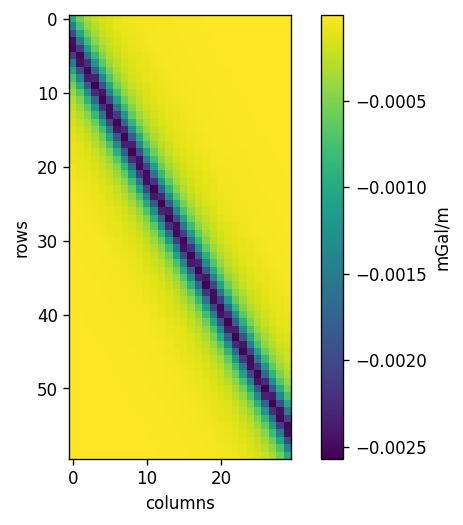

In [7]:
parameters = np.zeros(30) + 5000

jacobian = make_jacobian(parameters, basin_boundaries, density, x)

plt.figure()
plt.imshow(jacobian)
plt.colorbar(label="mGal/m")
plt.xlabel("columns")
plt.ylabel("rows")
plt.show()

In [8]:
def basin2d_inversion(x, data, basin_boundaries, density, initial, max_iterations=10):
    """
    Solve the inverse problem using the Gauss-Newton method.
    """
    parameters = initial.astype(np.float64).copy() 
    predicted = cc.forward_model(parameters, basin_boundaries, density, x)
    residuals = data - predicted
    goal_function = [np.linalg.norm(residuals)**2]
    for i in range(max_iterations):       
        jacobian = make_jacobian(parameters, basin_boundaries, density, x)
        hessian = jacobian.T @ jacobian
        gradient = jacobian.T @ residuals
        deltap = np.linalg.solve(hessian, gradient)
        new_parameters = parameters + deltap
        predicted = cc.forward_model(new_parameters, basin_boundaries, density, x)
        residuals = data - predicted
        current_goal = np.linalg.norm(residuals)**2
        if current_goal > goal_function[-1]:
            break
        parameters = new_parameters
        goal_function.append(current_goal)
    return parameters, goal_function

In [9]:
estimated, goal_function = basin2d_inversion(
    x, data, basin_boundaries, density, initial=np.full(30, 0),
)
predicted = cc.forward_model(estimated, basin_boundaries, density, x)

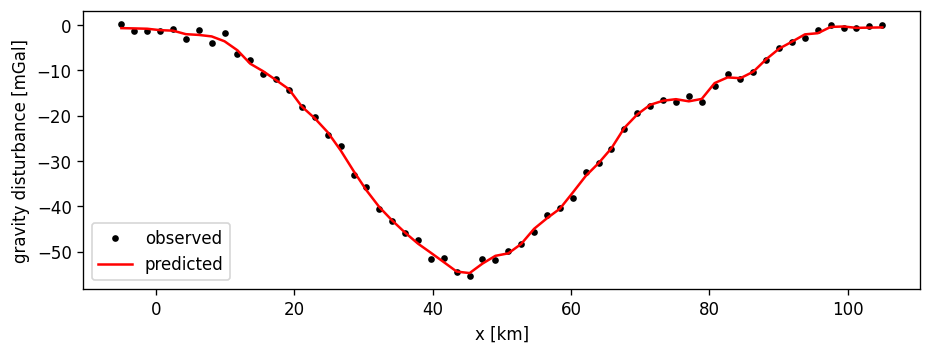

In [10]:
plt.figure(figsize=(9, 3))
plt.plot(x / 1e3, data, ".k", label="observed")
plt.plot(x / 1e3, predicted, "-r", label='predicted')
plt.legend()
plt.xlabel("x [km]")
plt.ylabel("gravity disturbance [mGal]")
plt.show()

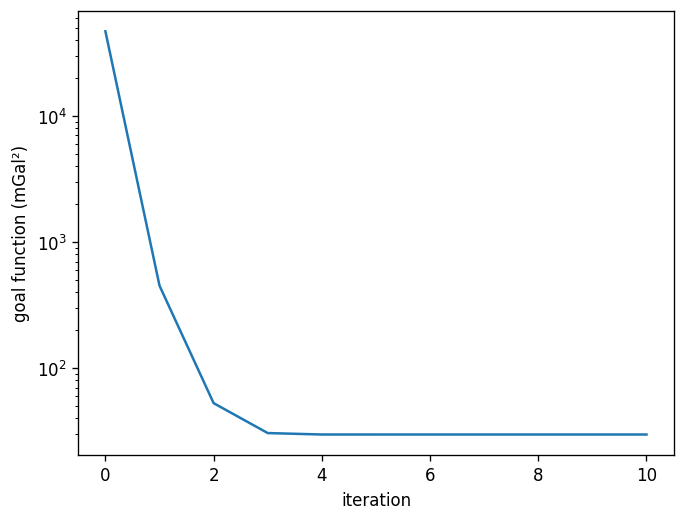

In [11]:
plt.figure()
plt.plot(goal_function)
plt.yscale("log")
plt.xlabel("iteration")
plt.ylabel("goal function (mGal²)")
plt.show()

<Axes: xlabel='x [km]', ylabel='depth [km]'>

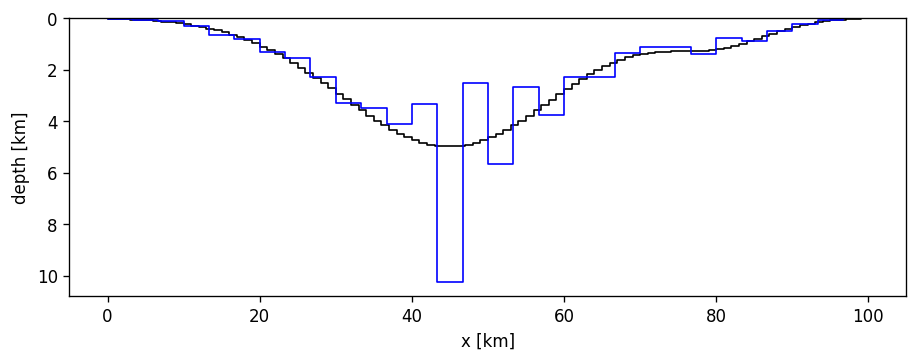

In [12]:
ax = cc.plot_prisms(depths, basin_boundaries)
cc.plot_prisms(estimated, basin_boundaries, edgecolor="blue", ax=ax)